In [3]:
!pip install sentencepiece

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print("complete")

complete


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)

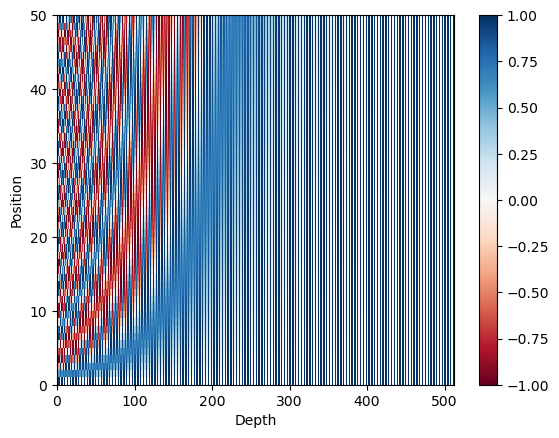

In [6]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [7]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


In [9]:
def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask

In [10]:
x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)

입력 텐서 크기 : torch.Size([2, 5])
생성된 마스크 크기 : torch.Size([2, 1, 1, 5])
tensor([[[[0., 0., 1., 0., 1.]]],


        [[[1., 1., 1., 0., 0.]]]])


In [11]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask

In [12]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [13]:
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[1., 1., 1., 1., 1.],
          [1., 0., 1., 1., 1.],
          [1., 0., 0., 1., 1.],
          [1., 0., 0., 0., 1.],
          [1., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2


In [15]:
class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out)
        out3 = self.norm3(out2 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [17]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_outputs, look_ahead_mask=None, padding_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, enc_outputs, look_ahead_mask, padding_mask)

        return x

In [18]:
# 한국어 전처리 함수
def preprocess_sentence(sentence):
    """
    한국어 문장 전처리
    - 양쪽 공백 제거
    - 특수문자 처리
    """
    sentence = sentence.strip()
    
    # 특수문자 앞뒤 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    # 한글, 영문, 숫자, 기본 특수문자만 남김
    sentence = re.sub(r"[^a-zA-Z0-9가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

print("전처리 함수 정의 완료")

전처리 함수 정의 완료


In [27]:
# 한국어 전처리 테스트
sample_sentence = "안녕하세요? 오늘 날씨가 정말 좋네요!"
preprocessed_sentence = preprocess_sentence(sample_sentence)
print("원본:", sample_sentence)
print("전처리 후:", preprocessed_sentence)

원본: 안녕하세요? 오늘 날씨가 정말 좋네요!
전처리 후: 안녕하세요 ? 오늘 날씨가 정말 좋네요 !


In [28]:
def load_chatbot_data(file_path, max_samples=50000):
    """
    ChatbotData.csv 파일 로딩
    columns: Q (질문), A (답변), label (감정 레이블)
    """
    print(f"데이터 로딩 중: {file_path}")
    df = pd.read_csv(file_path)
    
    print(f"원본 데이터 크기: {len(df)}")
    print(f"컬럼: {df.columns.tolist()}")
    
    # Q, A 컬럼만 사용
    pairs = []
    for idx, row in df.iterrows():
        q_text = str(row['Q']).strip()
        a_text = str(row['A']).strip()
        
        if q_text and a_text:  # 빈 문자열 제외
            pairs.append((q_text, a_text))
        
        if len(pairs) >= max_samples:
            break
    
    print(f"로딩 완료: {len(pairs)}개 샘플")
    return pairs

In [30]:
# 데이터 로딩
CSV_PATH = '/home/jovyan/work/transformer_chatbot/data/ChatbotData.csv'
MAX_SAMPLES = 50000

pairs = load_chatbot_data(CSV_PATH, max_samples=MAX_SAMPLES)

print(f'\n전체 샘플 수: {len(pairs)}')
print(f'\n샘플 예시 (처음 3개):')
for i in range(min(3, len(pairs))):
    print(f'Q: {pairs[i][0]}')
    print(f'A: {pairs[i][1]}')
    print()

데이터 로딩 중: /home/jovyan/work/transformer_chatbot/data/ChatbotData.csv
원본 데이터 크기: 11823
컬럼: ['Q', 'A', 'label']
로딩 완료: 11823개 샘플

전체 샘플 수: 11823

샘플 예시 (처음 3개):
Q: 12시 땡!
A: 하루가 또 가네요.

Q: 1지망 학교 떨어졌어
A: 위로해 드립니다.

Q: 3박4일 놀러가고 싶다
A: 여행은 언제나 좋죠.



In [32]:
# SentencePiece 학습용 코퍼스 파일 생성
corpus_file = "chatbot_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a in pairs:
        # 전처리 적용
        q_processed = preprocess_sentence(q)
        a_processed = preprocess_sentence(a)
        f.write(q_processed + "\n")
        f.write(a_processed + "\n")

print(f'코퍼스 파일 생성 완료: {corpus_file}')

코퍼스 파일 생성 완료: chatbot_corpus.txt


In [33]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="spm_chatbot",  # ← 변경
    vocab_size=8000,
    character_coverage=0.9995,  # ← 변경 (한국어 권장값)
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,
    eos_id=2,
    pad_id=0,
    unk_id=3
)

print('SentencePiece 모델 학습 완료')

SentencePiece 모델 학습 완료


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: chatbot_corpus.txt
  input_format: 
  model_prefix: spm_chatbot
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 999999
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
 

In [34]:
sp = spm.SentencePieceProcessor()
sp.Load("spm_chatbot.model")  # ← 모델 이름 변경

True

In [35]:
# 한국어 토크나이저 테스트
sample_sentence = pairs[0][0]  # 첫 번째 질문 사용
print(f"원본: {sample_sentence}")

sentence = preprocess_sentence(sample_sentence)
print(f"전처리 후: {sentence}")

# 토크나이징
tokens = sp.encode(sentence, out_type=str)
print(f"Tokenized: {tokens}")

# 인코딩
encoded = sp.encode(sentence, out_type=int)
print(f"Encoded: {encoded}")

# 디코딩
decoded = sp.decode(encoded)
print(f"Decoded: {decoded}")

원본: 12시 땡!
전처리 후: 12시 땡 !
Tokenized: ['▁12', '시', '▁땡', '▁!']
Encoded: [5553, 6971, 3202, 108]
Decoded: 12시 땡 !


In [36]:
class ChatbotDataset(Dataset):
    def __init__(self, pairs, sp, max_length=40):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.data = []

        for q_text, a_text in pairs:
            # 1) 토크나이즈
            q_ids = sp.EncodeAsIds(q_text)
            a_ids = sp.EncodeAsIds(a_text)

            # 2) [CLS]/[SEP] 같은 별도 스페셜 토큰을 쓸 수도 있으나,
            #    여기서는 SentencePiece 기본 <s>, </s> 등 혹은 사용자 정의 토큰 활용 가능
            #    간단히 <s>=sp.bos_id(), </s>=sp.eos_id()로 가정해본다면:
            #    sp.SetEncodeExtraOptions("bos:eos") 등으로 설정하는 방법도 있음.
            # 여기서는 수동으로 bos/eos id를 붙인다고 가정
            bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1  # 혹은 임의값
            eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2

            q_tokens = [bos_id] + q_ids + [eos_id]
            a_tokens = [bos_id] + a_ids + [eos_id]

            # 3) 길이 제한
            if len(q_tokens) > max_length or len(a_tokens) > max_length:
                continue

            # 4) 고정 길이 패딩
            q_tokens += [0]*(max_length - len(q_tokens))  # 0 -> <pad> 가정
            a_tokens += [0]*(max_length - len(a_tokens))

            # 5) 디코더 입력(dec_input): a_tokens[:-1], 타겟(outputs): a_tokens[1:]
            #    (teacher forcing용)
            dec_input = a_tokens[:-1]
            target = a_tokens[1:]

            self.data.append({
                "enc_input": q_tokens,
                "dec_input": dec_input,
                "target": target
            })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        enc_input = torch.tensor(sample["enc_input"], dtype=torch.long)
        dec_input = torch.tensor(sample["dec_input"], dtype=torch.long)
        target = torch.tensor(sample["target"], dtype=torch.long)
        return enc_input, dec_input, target

In [37]:
dataset = ChatbotDataset(pairs, sp, max_length=40)

In [38]:
for encoder_input, decoder_input, decoder_label  in dataset:
    print("텐서 크기 :",encoder_input.size())
    print(encoder_input)
    print(sp.decode(encoder_input.tolist()))
    print(decoder_input)
    print(sp.decode(decoder_input.tolist()))
    print(decoder_label)
    print(sp.decode(decoder_label.tolist()))
    break

텐서 크기 : torch.Size([40])
tensor([   1, 5553, 6971, 3202, 7077,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
12시 땡!
tensor([   1, 4486,  214, 5923, 6930,    2,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요.
tensor([4486,  214, 5923, 6930,    2,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0])
하루가 또 가네요.


In [39]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [40]:
for encoder_input, decoder_input, decoder_label in dataloader:
    print(encoder_input.size())
    print(decoder_input.size())
    print(decoder_label.size())
    break

torch.Size([32, 40])
torch.Size([32, 39])
torch.Size([32, 39])


In [41]:
class Transformer(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 인코더/디코더 층 수
                 units,           # feed-forward 네트워크의 중간 차원(ff_dim)
                 d_model,         # 임베딩 및 내부 표현 차원
                 num_heads,       # 멀티헤드 어텐션의 헤드 수
                 dropout=0.1):
        super(Transformer, self).__init__()

        # 인코더
        self.encoder = Encoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 디코더
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 출력층: (d_model) -> (vocab_size)
        self.final_linear = nn.Linear(d_model, vocab_size)

        # 참고: 텐서플로우 코드의 `name="transformer"`는 파이토치에선 보통 사용 안 함

    def forward(self, inputs, dec_inputs):
        # 1) 인코더 패딩 마스크 생성
        enc_padding_mask = create_padding_mask(inputs)     # shape (batch_size, 1, 1, src_seq_len)

        # 2) 디코더 look-ahead + 패딩 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # shape (batch_size, 1, tgt_seq_len, tgt_seq_len)

        # 3) 디코더에서 인코더 출력 쪽을 마스킹할 때 쓸 패딩 마스크
        dec_padding_mask = create_padding_mask(inputs)        # shape (batch_size, 1, 1, src_seq_len)

        # 4) 인코더 수행
        enc_outputs = self.encoder(
            x=inputs,
            mask=enc_padding_mask
        )  # shape: (batch_size, src_seq_len, d_model)

        # 5) 디코더 수행
        dec_outputs = self.decoder(
            x=dec_inputs,           # (batch_size, tgt_seq_len)
            enc_outputs=enc_outputs,# (batch_size, src_seq_len, d_model)
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )  # shape: (batch_size, tgt_seq_len, d_model)

        # 6) 최종 Dense (vocab_size)
        logits = self.final_linear(dec_outputs)  # (batch_size, tgt_seq_len, vocab_size)
        return logits

In [42]:
# 예: 하이퍼파라미터 설정
NUM_LAYERS = 2     # 인코더/디코더 층 수
D_MODEL = 256      # 임베딩 및 내부 표현 차원
NUM_HEADS = 8      # 멀티헤드 어텐션에서의 헤드 수
UNITS = 512        # 피드포워드 신경망의 은닉 차원
DROPOUT = 0.1      # 드롭아웃 비율
VOCAB_SIZE = 8000 # 단어 집합 크기(예시)

# 모델 생성
model = Transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT
)

print(model)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(8000, 256)
    (pos_encoding): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiHeadAttention(
          (query_dense): Linear(in_features=256, out_features=256, bias=True)
          (key_dense): Linear(in_features=256, out_features=256, bias=True)
          (value_dense): Linear(in_features=256, out_features=256, bias=True)
          (out_dense): Linear(in_features=256, out_features=256, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=256, bias=True)
        )
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): LayerNorm((256,), eps=1e-06, elementwise_aff

In [43]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

In [44]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

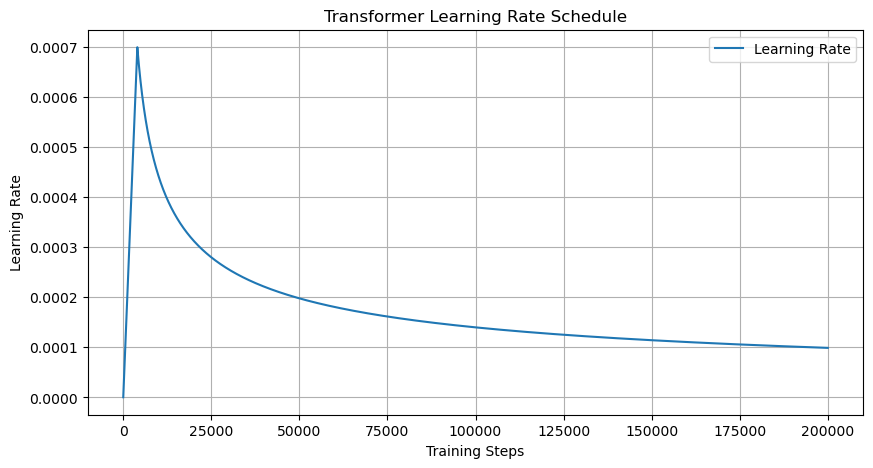

In [45]:
# 하이퍼파라미터 설정
d_model = 512
warmup_steps = 4000
total_steps = 200000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


In [46]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-9)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def accuracy_function(y_pred, y_true, pad_id=0):
    """
    y_pred: (batch_size, seq_len, vocab_size)
    y_true: (batch_size, seq_len)
    """
    preds = y_pred.argmax(dim=-1)  # (batch_size, seq_len)
    mask = (y_true != pad_id)
    correct = (preds == y_true) & mask
    acc = correct.float().sum() / mask.float().sum()
    return acc

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [48]:
def train_step(model, batch, optimizer, loss_function, device):
    model.train()
    enc_input, dec_input, target = [x.to(device) for x in batch]

    optimizer.zero_grad()

    # 모델 포워드 패스
    logits = model(enc_input, dec_input)  # (batch_size, seq_len, vocab_size)

    # Loss 계산 (패딩 토큰 무시)
    loss = loss_function(logits.permute(0, 2, 1), target)  # (batch_size, vocab_size, seq_len) 필요

    # Backpropagation
    loss.backward()
    optimizer.step()

    return loss.item(), accuracy_function(logits, target, pad_id=sp.pad_id())

In [49]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0, 0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device)
            total_loss += loss
            total_acc += acc

            # 일정 스텝마다 로그 출력
            if step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

            # 학습률 스케줄러 업데이트
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)
        print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

In [59]:
%%time

train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=300,  # 원하는 에폭 수
    device=device
)

[Epoch 1, Step 0] Loss: 6.0548, Acc: 0.2719
[Epoch 1, Step 100] Loss: 5.6537, Acc: 0.3262
[Epoch 1, Step 200] Loss: 5.7612, Acc: 0.3065
[Epoch 1, Step 300] Loss: 5.5608, Acc: 0.3232
Epoch 1 Completed - Avg Loss: 5.9141, Avg Acc: 0.2925
[Epoch 2, Step 0] Loss: 5.6807, Acc: 0.3247
[Epoch 2, Step 100] Loss: 5.9805, Acc: 0.2740
[Epoch 2, Step 200] Loss: 5.9292, Acc: 0.2731
[Epoch 2, Step 300] Loss: 5.9027, Acc: 0.2759
Epoch 2 Completed - Avg Loss: 5.9105, Avg Acc: 0.2924
[Epoch 3, Step 0] Loss: 5.6650, Acc: 0.3010
[Epoch 3, Step 100] Loss: 6.2290, Acc: 0.2661
[Epoch 3, Step 200] Loss: 5.9834, Acc: 0.2591
[Epoch 3, Step 300] Loss: 5.7632, Acc: 0.3184
Epoch 3 Completed - Avg Loss: 5.9049, Avg Acc: 0.2926
[Epoch 4, Step 0] Loss: 5.8655, Acc: 0.3128
[Epoch 4, Step 100] Loss: 5.9340, Acc: 0.2754
[Epoch 4, Step 200] Loss: 5.7372, Acc: 0.3384
[Epoch 4, Step 300] Loss: 5.8693, Acc: 0.3216
Epoch 4 Completed - Avg Loss: 5.9002, Avg Acc: 0.2927
[Epoch 5, Step 0] Loss: 5.7501, Acc: 0.2963
[Epoch 5, St

In [60]:
def decoder_inference(model, sentence, tokenizer, device='cpu'):
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN = tokenizer.eos_id()
    MAX_LENGTH = 40


    # 전처리
    sentence = preprocess_sentence(sentence)

    # 인코더 입력: [START] + 인코딩 + [END]
    enc_input_ids = [START_TOKEN] + tokenizer.encode(sentence) + [END_TOKEN]
    # 차원 확장: (batch_size=1, seq_len)
    enc_input = torch.tensor([enc_input_ids], dtype=torch.long, device=device)

    # 디코더 입력(dec_input)을 START_TOKEN만 포함한 상태로 시작
    dec_input = torch.tensor([[START_TOKEN]], dtype=torch.long, device=device)

    model.eval()  # 모델 평가 모드
    with torch.no_grad():
        for i in range(MAX_LENGTH):
            # 모델 forward: (enc_input, dec_input) -> (batch_size=1, seq_len, vocab_size)
            logits = model(enc_input, dec_input)

            # 마지막 타임스텝의 예측만 추출: shape (1, 1, vocab_size)
            # logits[:, -1, :] -> (1, vocab_size)
            last_step_logits = logits[:, -1, :]

            # argmax로 가장 높은 확률의 토큰 선택
            predicted_id = torch.argmax(last_step_logits, dim=-1)  # shape: (1,)

            # 종료 토큰이면 중단
            if predicted_id.item() == END_TOKEN:
                break

            # 디코더 입력(dec_input)에 예측 토큰을 이어붙임
            predicted_id = predicted_id.unsqueeze(0)  # shape (1,1)
            dec_input = torch.cat([dec_input, predicted_id], dim=1)

    # 최종 시퀀스: dec_input: (1, seq_len)에서 (seq_len,)로
    output_sequence = dec_input.squeeze(0).tolist()  # e.g. [START_TOKEN, ..., 토큰들...]

    return output_sequence

In [61]:
def sentence_generation(model, sentence, tokenizer, device='cpu'):
    # 디코더 인퍼런스 -> 예측된 토큰 시퀀스
    output_seq = decoder_inference(model, sentence, tokenizer, device=device)

    # 토크나이저로 디코딩 (패딩, START/END 토큰 등은 제외하거나 처리)
    # 여기서는 단순히 tokenizer.decode() 직접 호출
    predicted_sentence = tokenizer.decode(
        [token for token in output_seq if token < tokenizer.GetPieceSize()]
    )

    print("입력 :", sentence)
    print("출력 :", predicted_sentence)
    return predicted_sentence

In [62]:
sentence = '1지망 학교 떨어졌어'
sentence_generation(model, sentence, sp, device)

입력 : 1지망 학교 떨어졌어
출력 : 잘 수 있을 거예요.


'잘 수 있을 거예요.'

In [67]:
sentence = "배 고프다"
sentence_generation(model, sentence, sp, device)

입력 : 배 고프다
출력 : 잘.


'잘.'